In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [2]:
dataset_all_cleaned = pd.read_pickle('../data/dataset_all_cleaned.df')

In [3]:
dataset_all_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28138 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   28138 non-null  object
 1   Label   28138 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 659.5+ KB


In [4]:
X = dataset_all_cleaned['Query']
y = dataset_all_cleaned['Label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [6]:
y_train.value_counts()

Label
0    13624
1     6072
Name: count, dtype: int64

In [7]:
y_test.value_counts()

Label
0    5842
1    2600
Name: count, dtype: int64

In [8]:
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=2500)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [9]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_train_tfidfvec = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidfvec = tfidf_vectorizer.transform(X_test)

In [10]:
with open('../model/tfidf_vec.sav', 'wb') as file:
  pickle.dump(tfidf_vectorizer, file)

In [11]:
def eval_model(model, train_data, train_label, model_name = 'Model', cv=3):
  print(f'Evaluating {model_name}...')
  global X_test_tfidfvec
  global y_test
  train_acc_score = model.score(train_data, train_label)
  test_acc_score = model.score(X_test_tfidfvec, y_test)
  
  print('Training Accuracy = ',round(train_acc_score*100, 4), ' %')
  print('Testing Accuracy = ',round(test_acc_score*100, 4), ' %')
  
  y_predictions = model.predict(X_test_tfidfvec)
  print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,4)} %")
  confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

  cross_val_f1 = cross_val_score(model, train_data, train_label, cv=cv, scoring='f1')
  print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

  fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
  roc_auc = auc(fpr, tpr)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
  print("roc_auc = ", round(roc_auc*100,4))

  figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
  confusion_mat.plot(ax=ax1)
  ax1.set_title('Confustion matrix')
  roc_display.plot(ax=ax2)
  ax2.set_title('ROC-AUC')
  figure.suptitle(model_name)

In [12]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_tfidfvec, y_train)

KNeighborsClassifier()

Evaluating KNN Classifier...
Training Accuracy =  99.4517  %
Testing Accuracy =  99.467  %
F1 Score for KNN Classifier: 99.1294 %
cross_validation f1-scores for KNN Classifier 
 [0.98371336 0.98751872 0.98701947]
roc_auc =  99.2093


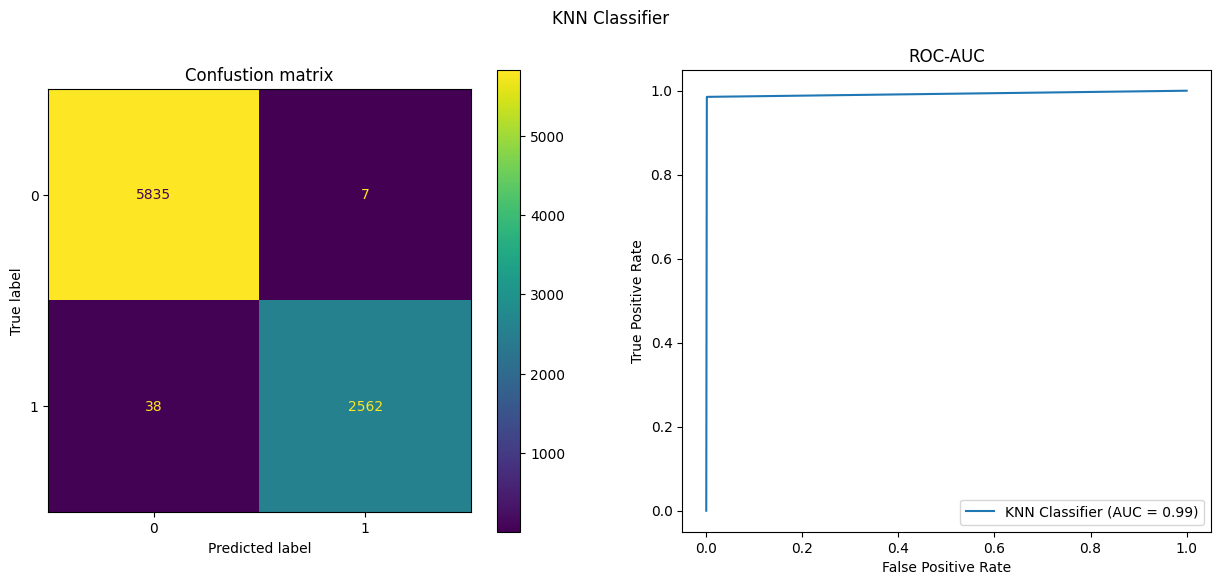

In [13]:
eval_model(knn_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='KNN Classifier')

In [14]:
knn_model_gcv = KNeighborsClassifier()
knn_params = {'n_neighbors':(1,3,5,7,9,11,13,19), 'metric':('euclidean','minkowski')}

In [15]:
knn_clf_gcv = GridSearchCV(estimator = knn_model_gcv, param_grid = knn_params, n_jobs=-1, scoring='f1')

In [16]:
knn_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ('euclidean', 'minkowski'),
                         'n_neighbors': (1, 3, 5, 7, 9, 11, 13, 19)},
             scoring='f1')

In [17]:
cv_results = pd.DataFrame(knn_clf_gcv.cv_results_)
cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
0,"{'metric': 'euclidean', 'n_neighbors': 1}",0.990968,0.000962,1
8,"{'metric': 'minkowski', 'n_neighbors': 1}",0.990968,0.000962,1
1,"{'metric': 'euclidean', 'n_neighbors': 3}",0.988362,0.000747,3
9,"{'metric': 'minkowski', 'n_neighbors': 3}",0.988362,0.000747,3
2,"{'metric': 'euclidean', 'n_neighbors': 5}",0.986595,0.001870,5
10,"{'metric': 'minkowski', 'n_neighbors': 5}",0.986595,0.001870,5
3,"{'metric': 'euclidean', 'n_neighbors': 7}",0.985912,0.001935,7
11,"{'metric': 'minkowski', 'n_neighbors': 7}",0.985912,0.001935,7
5,"{'metric': 'euclidean', 'n_neighbors': 11}",0.985739,0.001879,9
13,"{'metric': 'minkowski', 'n_neighbors': 11}",0.985739,0.001879,9


<Axes: xlabel='param_n_neighbors', ylabel='mean_test_score'>

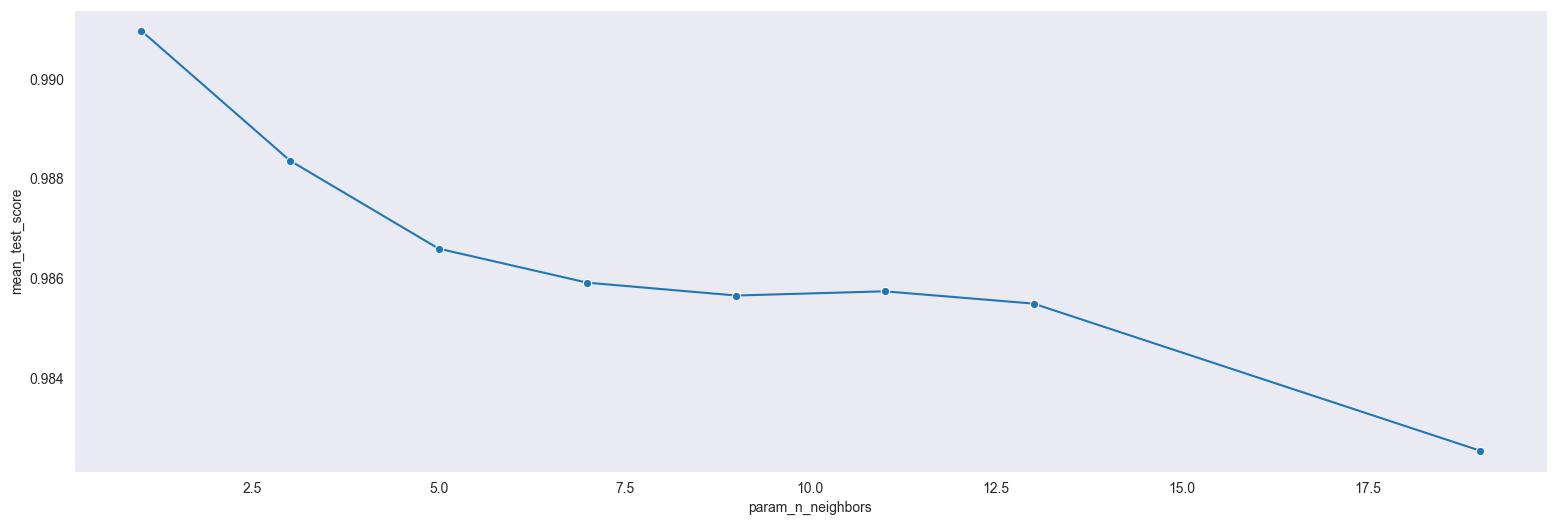

In [18]:
sns.set_style("dark")
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results[cv_results['param_metric']=='minkowski'], x='param_n_neighbors', y='mean_test_score', marker="o")

In [19]:
knn_model_tuned = KNeighborsClassifier(n_neighbors=7)

In [20]:
knn_model_tuned.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

Evaluating KNN Classifier tuned...
Training Accuracy =  99.2943  %
Testing Accuracy =  99.4906  %
F1 Score for KNN Classifier tuned: 99.1675 %
cross_validation f1-scores for KNN Classifier tuned 
 [0.98320381 0.98776529 0.98701299]
roc_auc =  99.2158


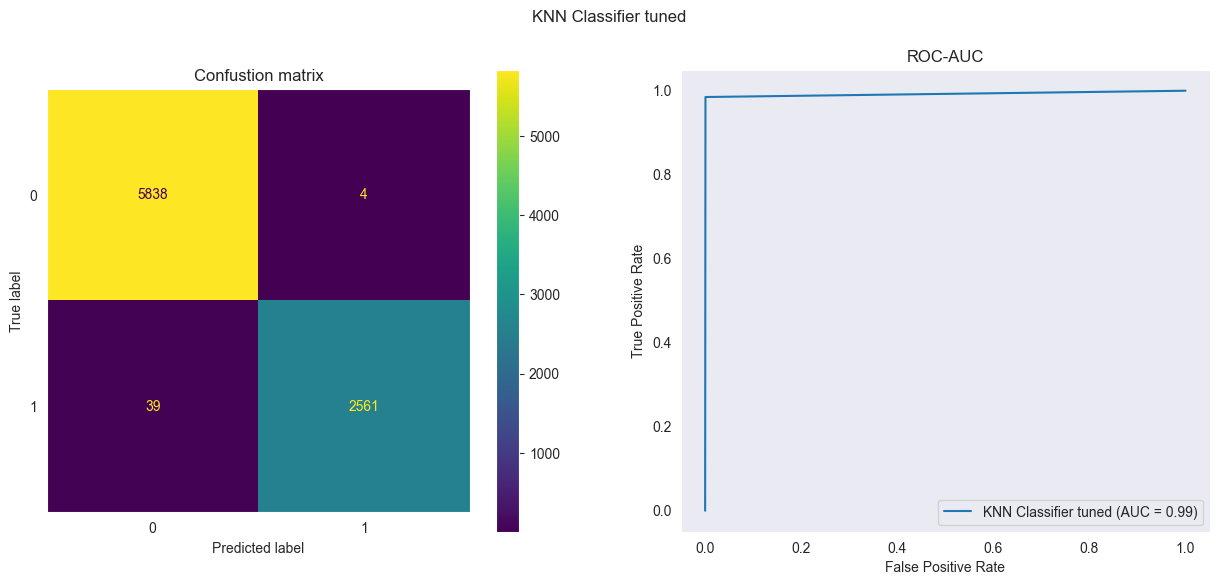

In [21]:
knn_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(knn_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='KNN Classifier tuned')

In [22]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidfvec, y_train)

MultinomialNB()

Evaluating Multinomial Naive Bayes...
Training Accuracy =  95.8723  %
Testing Accuracy =  95.5105  %
F1 Score for Multinomial Naive Bayes: 92.3512 %
cross_validation f1-scores for Multinomial Naive Bayes 
 [0.92364017 0.93402597 0.92440945]
roc_auc =  93.4266


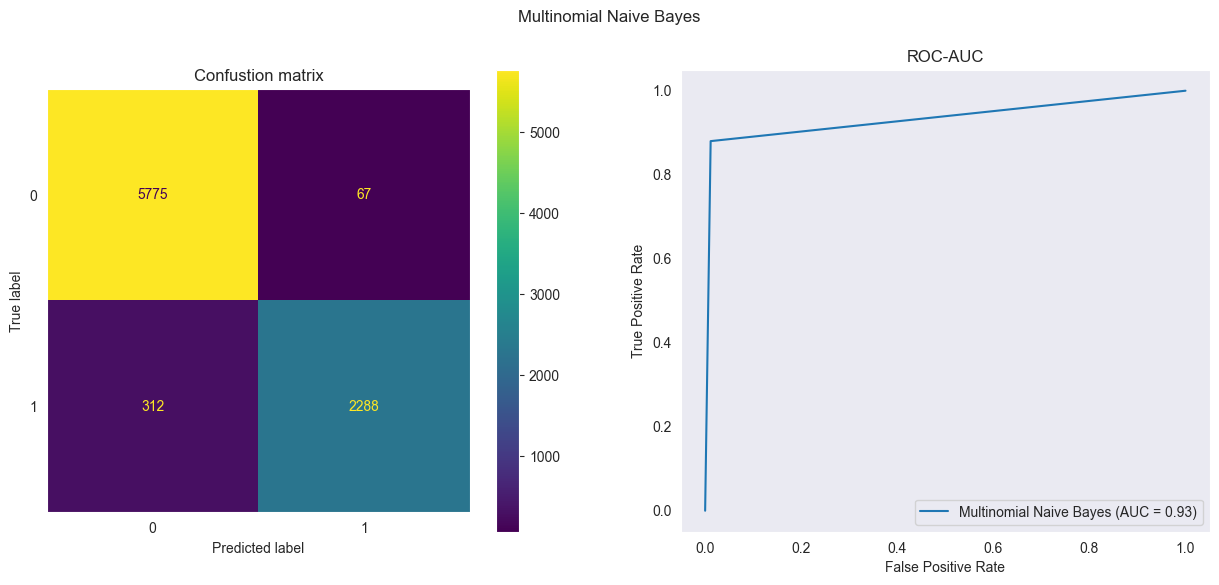

In [23]:
eval_model(mnb_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Multinomial Naive Bayes')

In [24]:
mnb_model_gcv = MultinomialNB()
mnb_params = {'alpha':(0, 0.1, 0.5, 1, 10, 100, 500)}

In [25]:
mnb_clf_gcv = GridSearchCV(estimator = mnb_model_gcv, param_grid = mnb_params, n_jobs=-1, scoring='f1')

In [26]:
mnb_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (0, 0.1, 0.5, 1, 10, 100, 500)},
             scoring='f1')

In [27]:
cv_results = pd.DataFrame(mnb_clf_gcv.cv_results_)
cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
0,{'alpha': 0},0.927735,0.004843,1
1,{'alpha': 0.1},0.927713,0.004493,2
2,{'alpha': 0.5},0.927699,0.004328,3
3,{'alpha': 1},0.927568,0.004508,4
4,{'alpha': 10},0.919646,0.004556,5
5,{'alpha': 100},0.606067,0.015504,6
6,{'alpha': 500},0.000000,0.000000,7


<Axes: xlabel='param_alpha', ylabel='mean_test_score'>

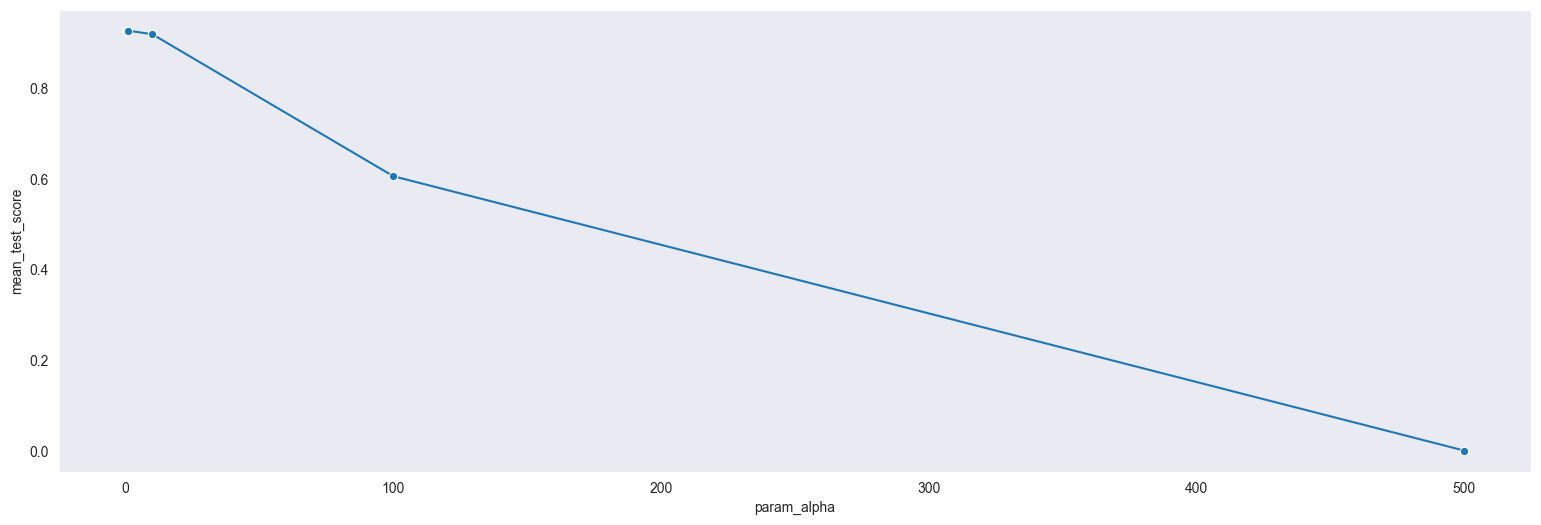

In [28]:
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_alpha', y='mean_test_score', marker="o")

In [29]:
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidfvec, y_train)

LogisticRegression()

Evaluating Logistic Regression...
Training Accuracy =  99.3095  %
Testing Accuracy =  99.3722  %
F1 Score for Logistic Regression: 98.9778 %
cross_validation f1-scores for Logistic Regression 
 [0.98602097 0.98829973 0.98779577]
roc_auc =  99.1835


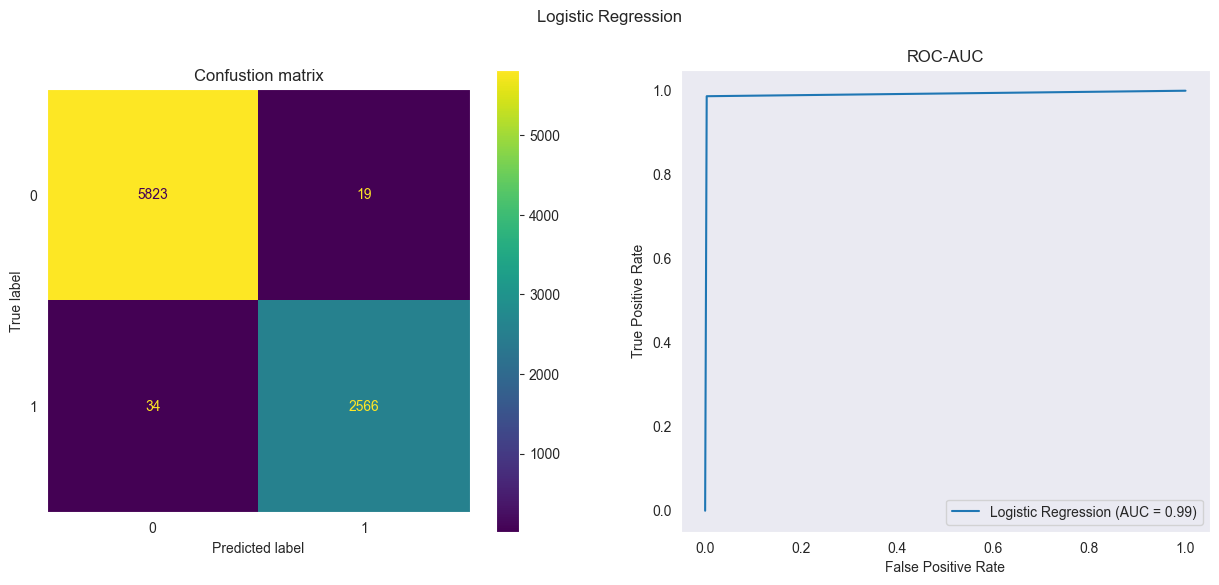

In [30]:
eval_model(lr_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Logistic Regression')

In [31]:
lr_model_gcv = LogisticRegression()
lr_params = {'C':(0.1, 0.5, 1.0, 5.0, 10.0), 'penalty':('l1', 'l2', 'elasticnet'), 'solver':('lbfgs', 'saga'), 'max_iter':[1000]}
lr_clf_gcv = GridSearchCV(estimator = lr_model_gcv, param_grid = lr_params, n_jobs=-1, scoring='f1')
lr_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0), 'max_iter': [1000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('lbfgs', 'saga')},
             scoring='f1')

In [32]:
cv_results = pd.DataFrame(lr_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
25,"{'C': 10.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.991051,0.001201,1
19,"{'C': 5.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.991049,0.001205,2
27,"{'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.991044,0.001510,3
26,"{'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.990960,0.001529,4
21,"{'C': 5.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.990042,0.001027,5
20,"{'C': 5.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.990042,0.001027,5
13,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.988963,0.001322,7
15,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.987792,0.001266,8
14,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.987792,0.001266,8
7,"{'C': 0.5, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.987215,0.001803,10


<Axes: xlabel='param_C', ylabel='mean_test_score'>

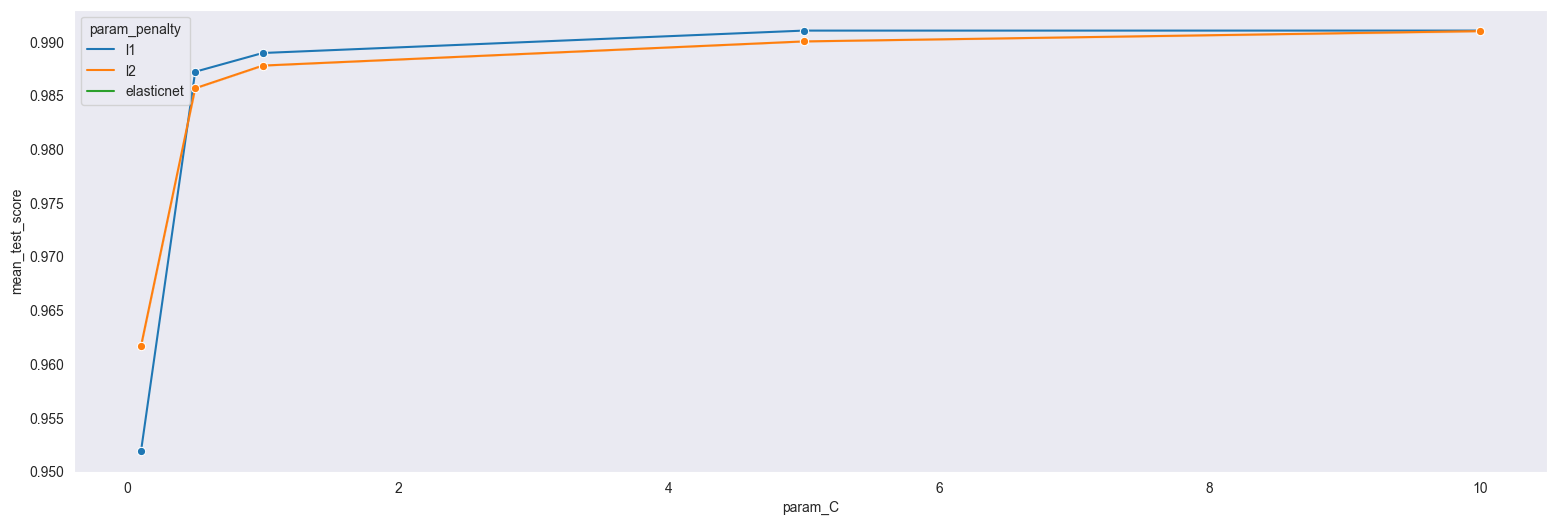

In [33]:
# fig, ax = plt.subplots(1,2,figsize=(19,6))
figure = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_C', y='mean_test_score', hue='param_penalty' ,marker="o")

In [34]:
lr_model_tuned = LogisticRegression(C=5.0, penalty='l1', solver= 'saga', max_iter=1000)
lr_model_tuned.fit(X_train_tfidfvec, y_train)

LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='saga')

Evaluating Logistic Regression Tuned...
Training Accuracy =  99.736  %
Testing Accuracy =  99.5854  %
F1 Score for Logistic Regression Tuned: 99.3237 %
cross_validation f1-scores for Logistic Regression Tuned 
 [0.98953662 0.99032018 0.99180531]
roc_auc =  99.3803


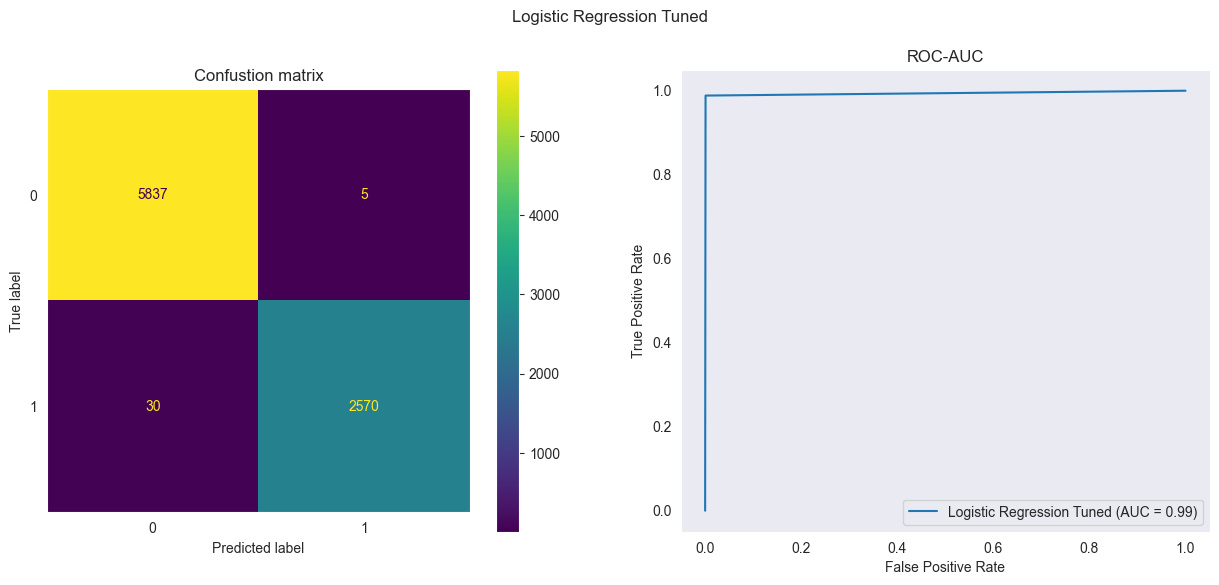

In [35]:
eval_model(lr_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='Logistic Regression Tuned')

In [36]:
svc_model = SVC()
svc_model.fit(X_train_tfidfvec, y_train)

SVC()

Evaluating Support Vector Classifier...
Training Accuracy =  99.736  %
Testing Accuracy =  99.6091  %
F1 Score for Support Vector Classifier: 99.3618 %
cross_validation f1-scores for Support Vector Classifier 
 [0.99128269 0.99279145 0.99054256]
roc_auc =  99.3867


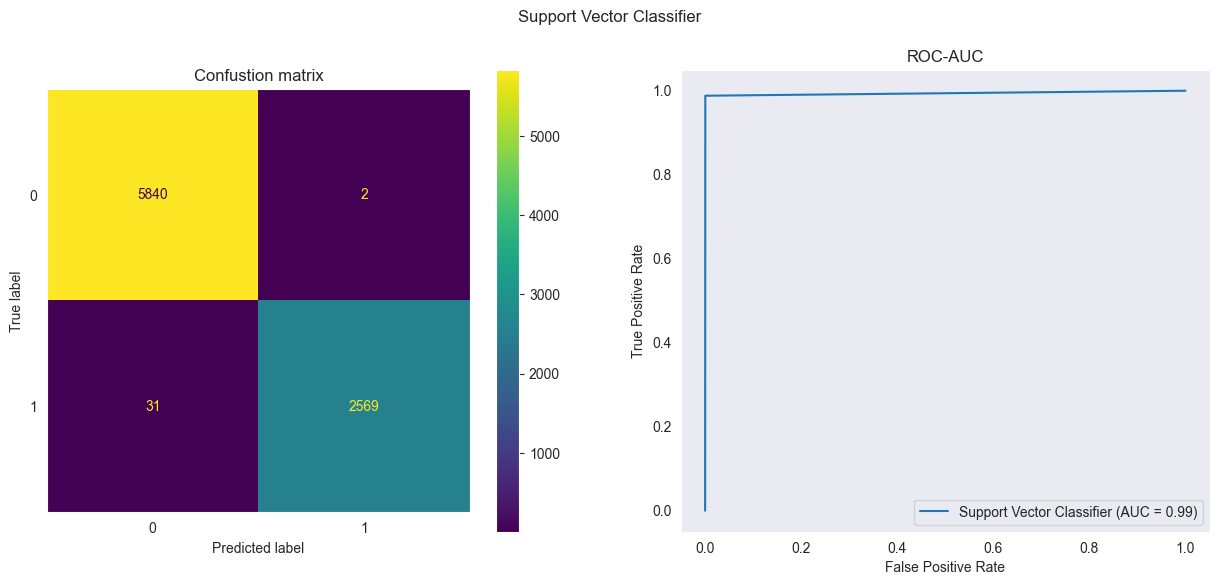

In [37]:
eval_model(svc_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Support Vector Classifier')

In [38]:
svc_model_gcv = SVC()
svc_params = {'kernel':('linear', 'rbf'), 'C':(0.1, 0.5, 1.0, 5.0, 10.0)}
svc_clf_gcv = GridSearchCV(estimator = svc_model_gcv, param_grid = svc_params, n_jobs=-1, scoring='f1')
svc_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0),
                         'kernel': ('linear', 'rbf')},
             scoring='f1')

In [39]:
cv_results = pd.DataFrame(svc_clf_gcv.cv_results_)
cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
6,"{'C': 5.0, 'kernel': 'linear'}",0.992548,0.000949,1
7,"{'C': 5.0, 'kernel': 'rbf'}",0.992379,0.000415,2
9,"{'C': 10.0, 'kernel': 'rbf'}",0.992379,0.000415,2
4,"{'C': 1.0, 'kernel': 'linear'}",0.992298,0.000773,4
8,"{'C': 10.0, 'kernel': 'linear'}",0.992132,0.000696,5
5,"{'C': 1.0, 'kernel': 'rbf'}",0.992044,0.000481,6
3,"{'C': 0.5, 'kernel': 'rbf'}",0.991120,0.000630,7
2,"{'C': 0.5, 'kernel': 'linear'}",0.990116,0.001704,8
1,"{'C': 0.1, 'kernel': 'rbf'}",0.987674,0.000864,9
0,"{'C': 0.1, 'kernel': 'linear'}",0.985714,0.000895,10


<Axes: xlabel='param_C', ylabel='mean_test_score'>

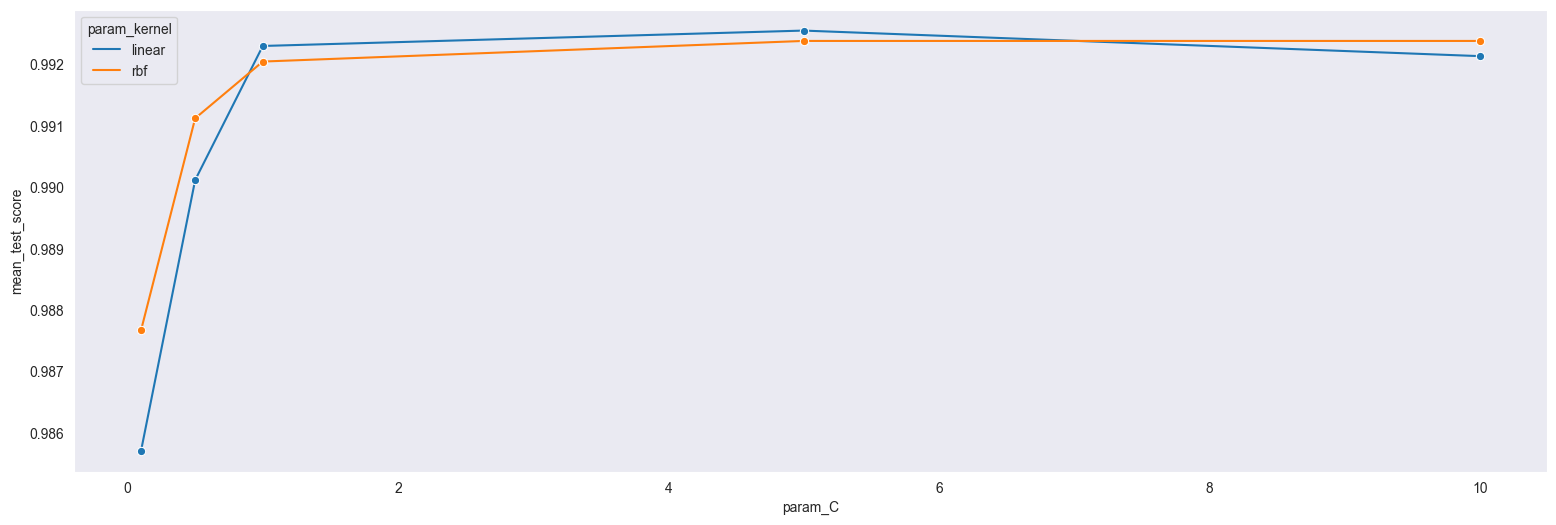

In [40]:
# fig, ax = plt.subplots(1,2,figsize=(19,6))
figure = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_C', y='mean_test_score', hue='param_kernel' ,marker="o")

Here we can see that linear SVC with C=5.0 is working best following by rbf kernel.

Evaluating Support Vector Classifier Tuned...
Training Accuracy =  99.7106  %
Testing Accuracy =  99.6209  %
F1 Score for Support Vector Classifier Tuned: 99.3815 %
cross_validation f1-scores for Support Vector Classifier Tuned 
 [0.98979846 0.99304521 0.99080745]
roc_auc =  99.4166


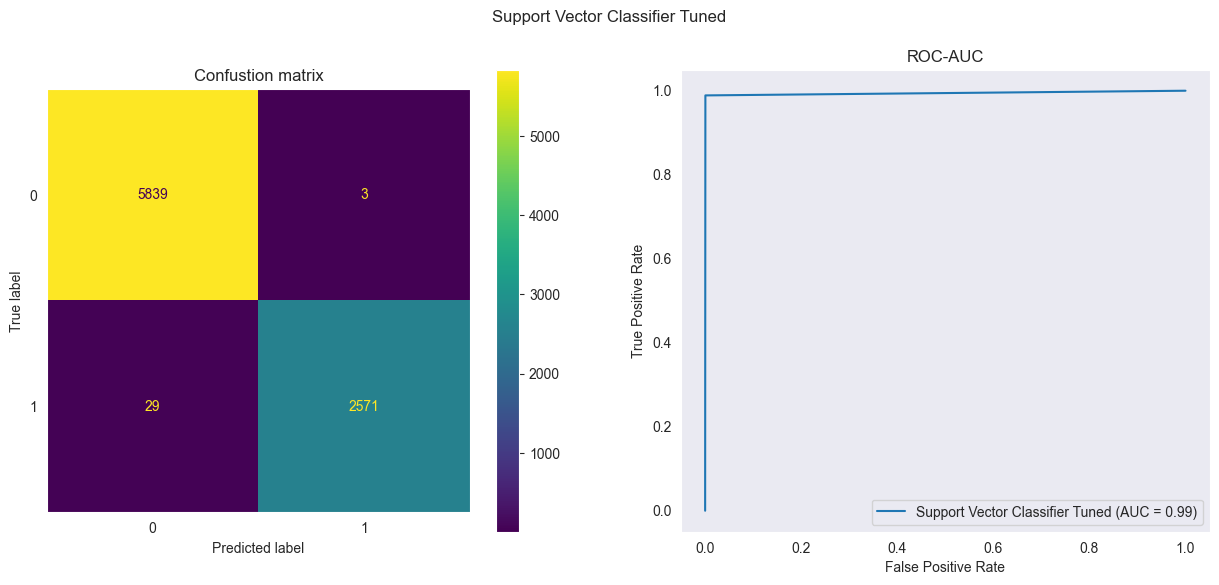

In [41]:
svc_model_tuned = SVC(kernel='linear', C=5.0)
svc_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(svc_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='Support Vector Classifier Tuned')

Evaluating Random Forest Classifier...
Training Accuracy =  99.7715  %
Testing Accuracy =  99.6209  %
F1 Score for Random Forest Classifier: 99.3818 %
cross_validation f1-scores for Random Forest Classifier 
 [0.99304175 0.99328859 0.99254473]
roc_auc =  99.4273


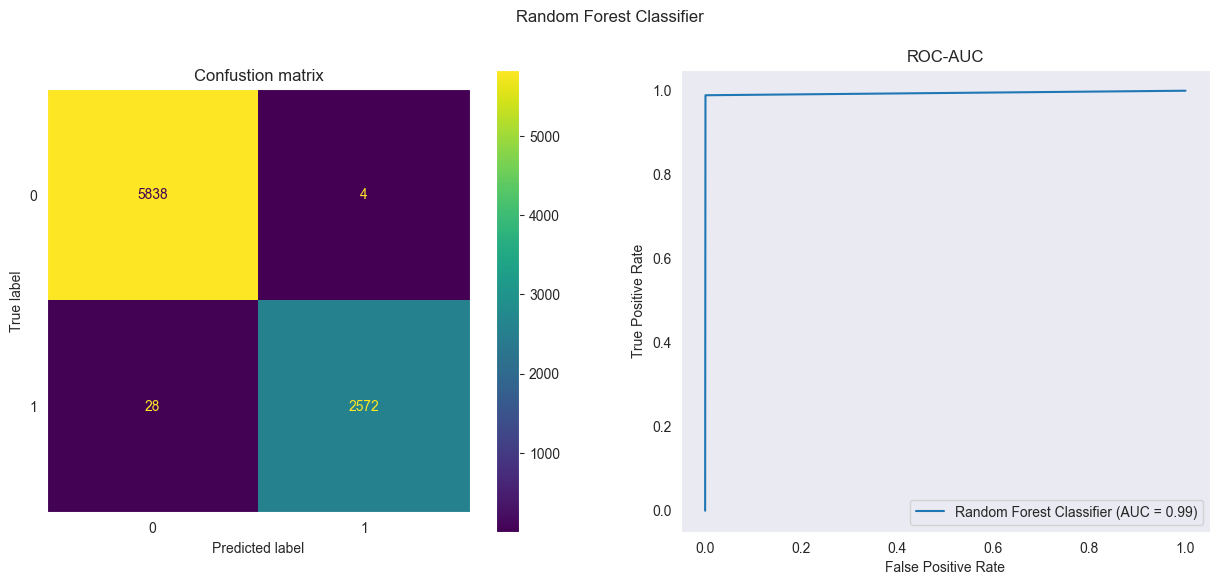

In [42]:
RFC_model = RandomForestClassifier()
RFC_model.fit(X_train_tfidfvec, y_train)
eval_model(RFC_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Random Forest Classifier')

In [43]:
RFC_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [44]:
RFC_model_gcv = RandomForestClassifier()
RFC_params = {'n_estimators':(10,50,100,200,300), 'class_weight':(None, 'balanced', 'balanced_subsample')}
RFC_clf_gcv = GridSearchCV(estimator = RFC_model_gcv, param_grid = RFC_params, n_jobs=-1, scoring='f1')
RFC_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': (None, 'balanced',
                                          'balanced_subsample'),
                         'n_estimators': (10, 50, 100, 200, 300)},
             scoring='f1')

In [45]:
cv_results = pd.DataFrame(RFC_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
8,"{'class_weight': 'balanced', 'n_estimators': 200}",0.993377,0.000376,1
14,"{'class_weight': 'balanced_subsample', 'n_estimators': 300}",0.993377,0.000376,1
1,"{'class_weight': None, 'n_estimators': 50}",0.993377,0.000698,3
10,"{'class_weight': 'balanced_subsample', 'n_estimators': 10}",0.993295,0.000305,4
11,"{'class_weight': 'balanced_subsample', 'n_estimators': 50}",0.993294,0.000167,5
3,"{'class_weight': None, 'n_estimators': 200}",0.993213,0.000333,6
13,"{'class_weight': 'balanced_subsample', 'n_estimators': 200}",0.993212,0.000208,7
7,"{'class_weight': 'balanced', 'n_estimators': 100}",0.993211,0.000329,8
12,"{'class_weight': 'balanced_subsample', 'n_estimators': 100}",0.993211,0.000329,8
2,"{'class_weight': None, 'n_estimators': 100}",0.993209,0.000337,10


<Axes: xlabel='param_n_estimators', ylabel='mean_test_score'>

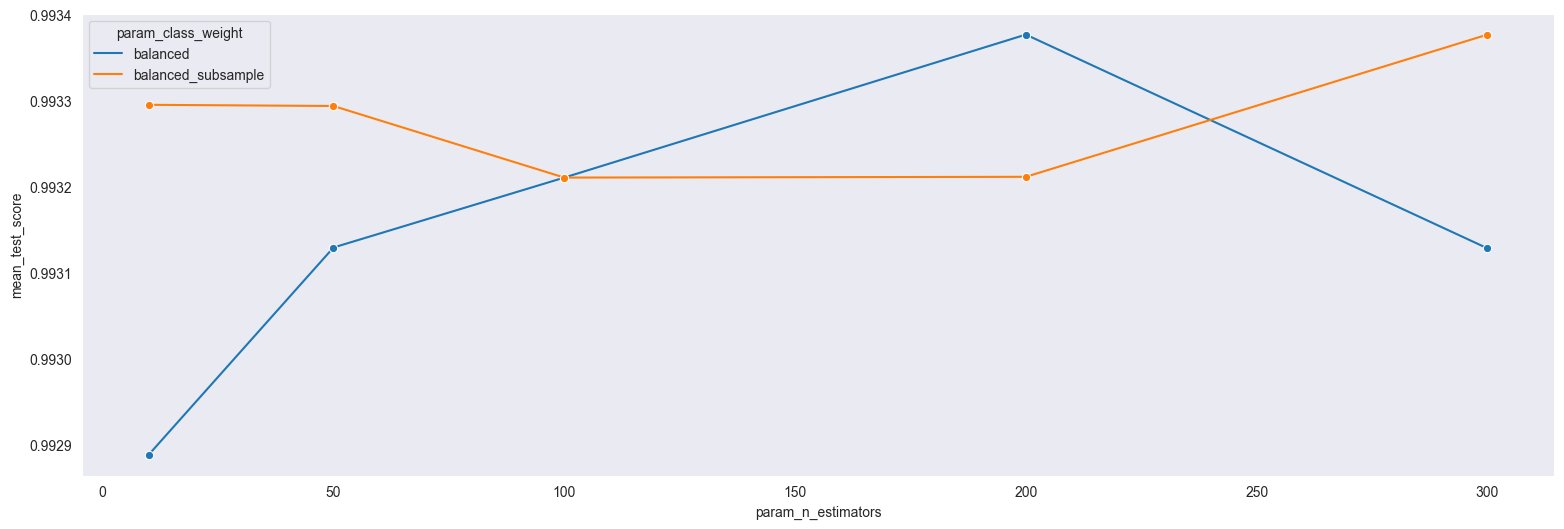

In [46]:
# fig, ax = plt.subplots(1,2,figsize=(19,6))
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_n_estimators', y='mean_test_score', hue='param_class_weight' ,marker="o")

Evaluating Random Forest Classifier Tuned...
Training Accuracy =  99.7715  %
Testing Accuracy =  99.6328  %
F1 Score for Random Forest Classifier Tuned: 99.401 %
cross_validation f1-scores for Random Forest Classifier Tuned 
 [0.99329193 0.99329526 0.99204376]
roc_auc =  99.4359


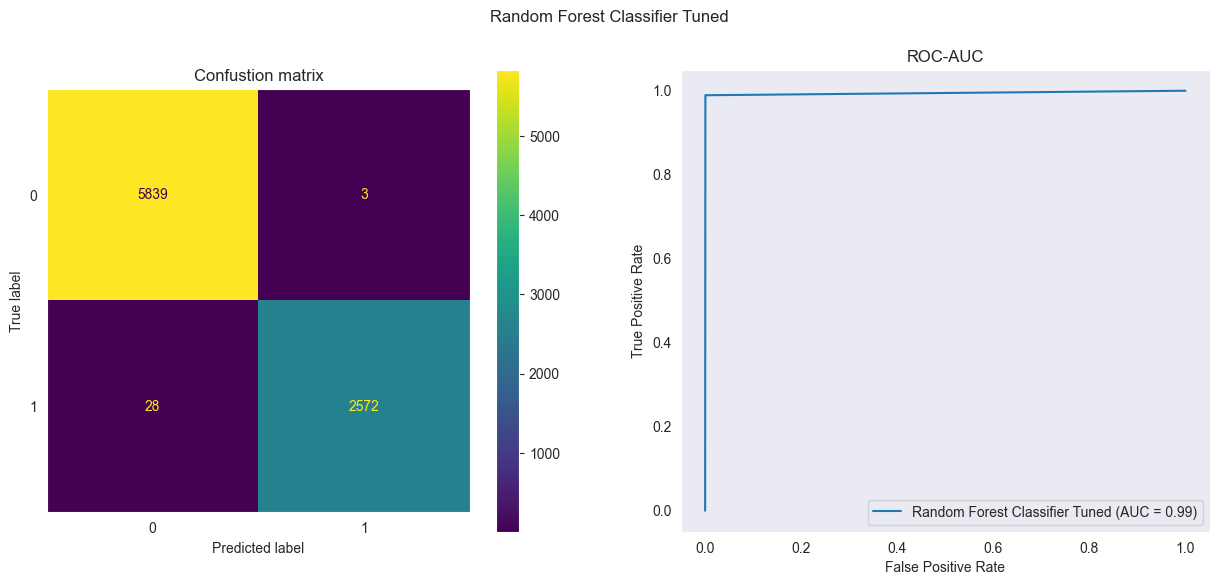

In [47]:
RFC_model_tuned = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200)
RFC_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(RFC_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='Random Forest Classifier Tuned')

Evaluating Random Forest Classifier Tuned 2...
Training Accuracy =  99.7715  %
Testing Accuracy =  99.6446  %
F1 Score for Random Forest Classifier Tuned 2: 99.4206 %
cross_validation f1-scores for Random Forest Classifier Tuned 2 
 [0.99329193 0.99304521 0.99229814]
roc_auc =  99.4658


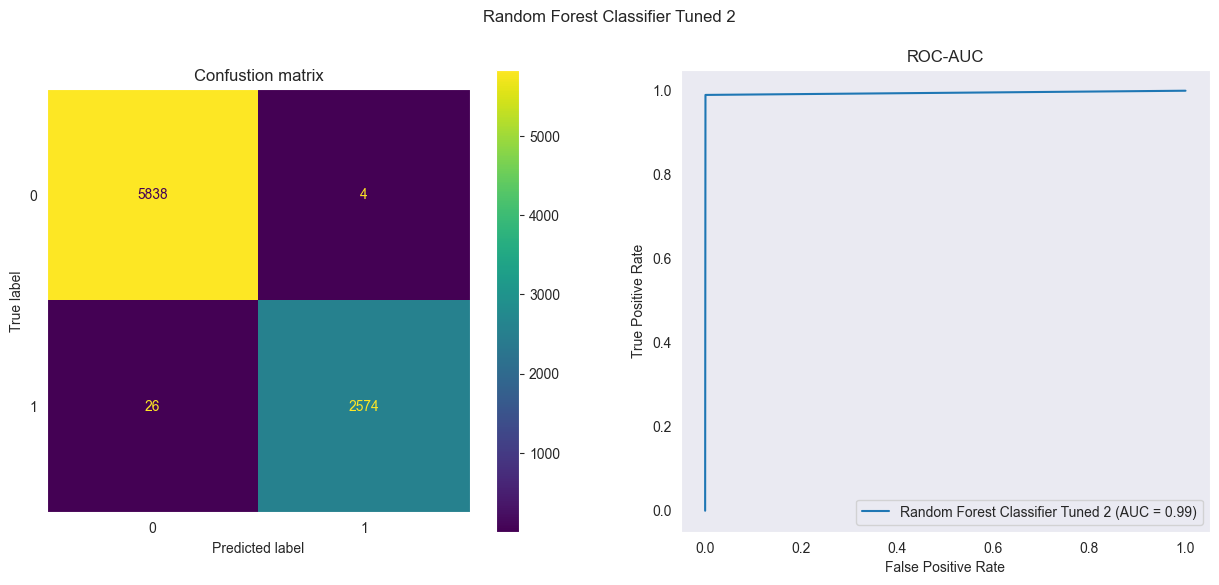

In [48]:
RFC_model_tuned_2 = RandomForestClassifier(class_weight='balanced', n_estimators=50)
RFC_model_tuned_2.fit(X_train_tfidfvec, y_train)
eval_model(RFC_model_tuned_2, train_data=X_train_tfidfvec, train_label=y_train, model_name='Random Forest Classifier Tuned 2')

Evaluating GBDT Classifier...
Training Accuracy =  99.1775  %
Testing Accuracy =  99.2419  %
F1 Score for GBDT Classifier: 98.7582 %
cross_validation f1-scores for GBDT Classifier 
 [0.98476904 0.98552894 0.9835    ]
roc_auc =  98.8653


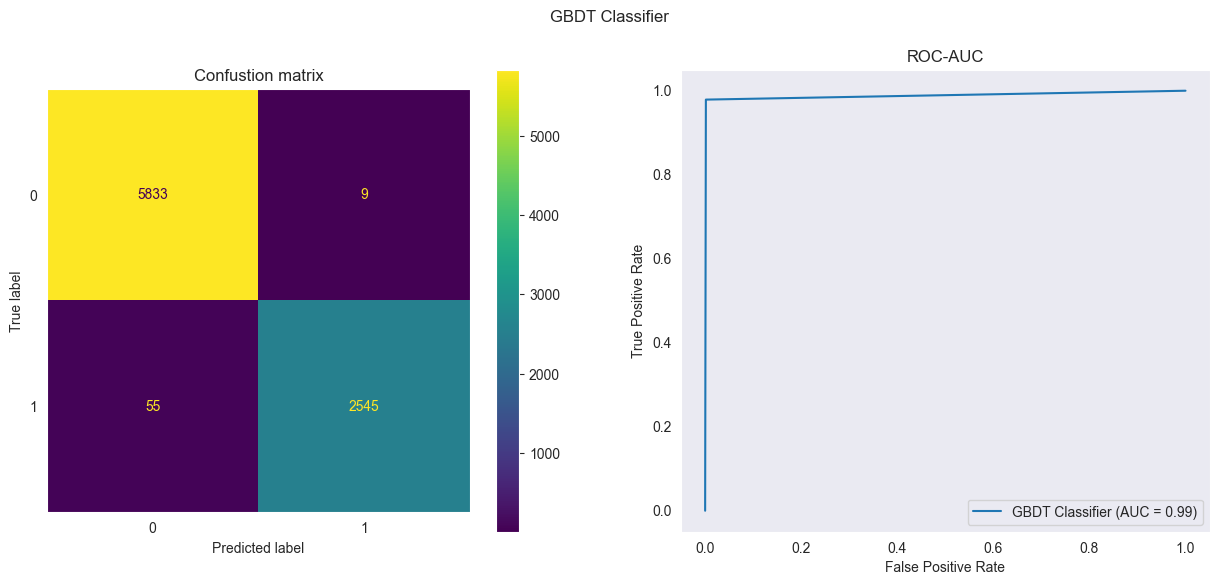

In [49]:
GBDT_model = GradientBoostingClassifier()
GBDT_model.fit(X_train_tfidfvec, y_train)
eval_model(GBDT_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='GBDT Classifier')

In [50]:
GBDT_model_gcv = GradientBoostingClassifier()
GBDT_params = {'n_estimators':(50,100,200,300), 'learning_rate':(0.01, 0.1, 0.5, 1.0)}
GBDT_clf_gcv = GridSearchCV(estimator = GBDT_model_gcv, param_grid = GBDT_params, n_jobs=-1, scoring='f1')
GBDT_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': (0.01, 0.1, 0.5, 1.0),
                         'n_estimators': (50, 100, 200, 300)},
             scoring='f1')

In [51]:
cv_results = pd.DataFrame(GBDT_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
7,"{'learning_rate': 0.1, 'n_estimators': 300}",0.989233,0.000526,1
11,"{'learning_rate': 0.5, 'n_estimators': 300}",0.988996,0.001607,2
10,"{'learning_rate': 0.5, 'n_estimators': 200}",0.988830,0.001507,3
9,"{'learning_rate': 0.5, 'n_estimators': 100}",0.988745,0.001319,4
8,"{'learning_rate': 0.5, 'n_estimators': 50}",0.988496,0.001399,5
6,"{'learning_rate': 0.1, 'n_estimators': 200}",0.987640,0.001290,6
15,"{'learning_rate': 1.0, 'n_estimators': 300}",0.984952,0.002982,7
5,"{'learning_rate': 0.1, 'n_estimators': 100}",0.984426,0.001738,8
14,"{'learning_rate': 1.0, 'n_estimators': 200}",0.983829,0.002899,9
12,"{'learning_rate': 1.0, 'n_estimators': 50}",0.983411,0.003171,10


<Axes: xlabel='param_n_estimators', ylabel='mean_test_score'>

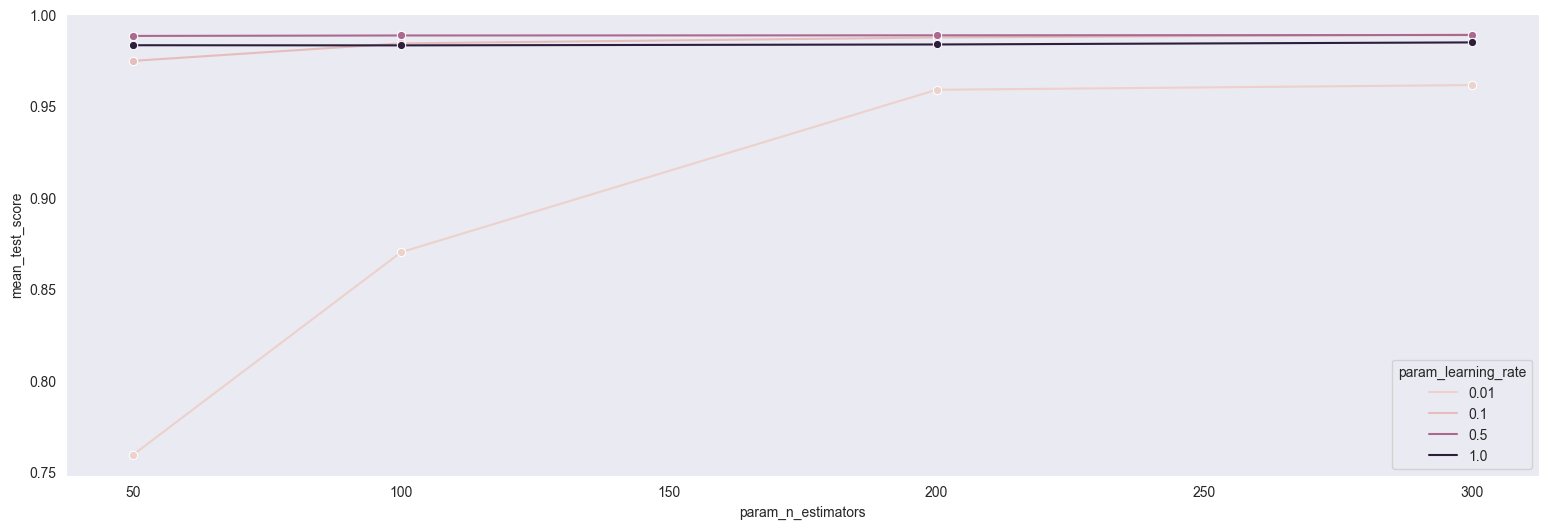

In [52]:
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate' ,marker="o")

Evaluating GBDT Classifier Tuned...
Training Accuracy =  99.6649  %
Testing Accuracy =  99.5143  %
F1 Score for GBDT Classifier Tuned: 99.2068 %
cross_validation f1-scores for GBDT Classifier Tuned 
 [0.98931677 0.99030574 0.98830555]
roc_auc =  99.2649


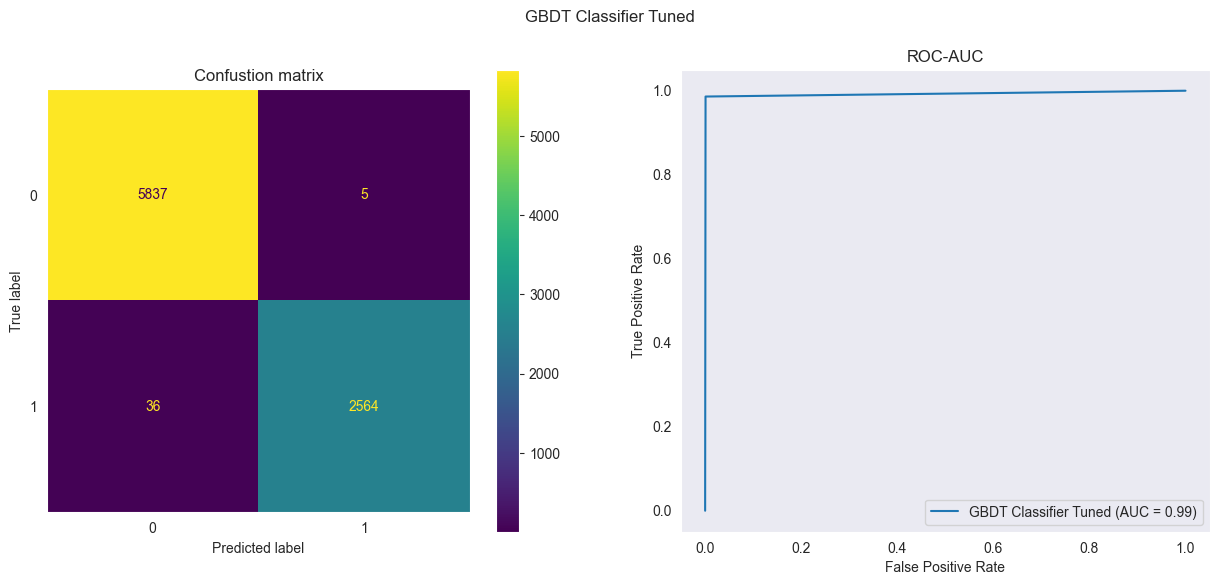

In [53]:
GBDT_model_tuned = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300)
GBDT_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(GBDT_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='GBDT Classifier Tuned')

Evaluating GBDT Classifier Tuned 2...
Training Accuracy =  99.7715  %
Testing Accuracy =  99.5262  %
F1 Score for GBDT Classifier Tuned 2: 99.226 %
cross_validation f1-scores for GBDT Classifier Tuned 2 
 [0.99005964 0.99031537 0.98855721]
roc_auc =  99.2735


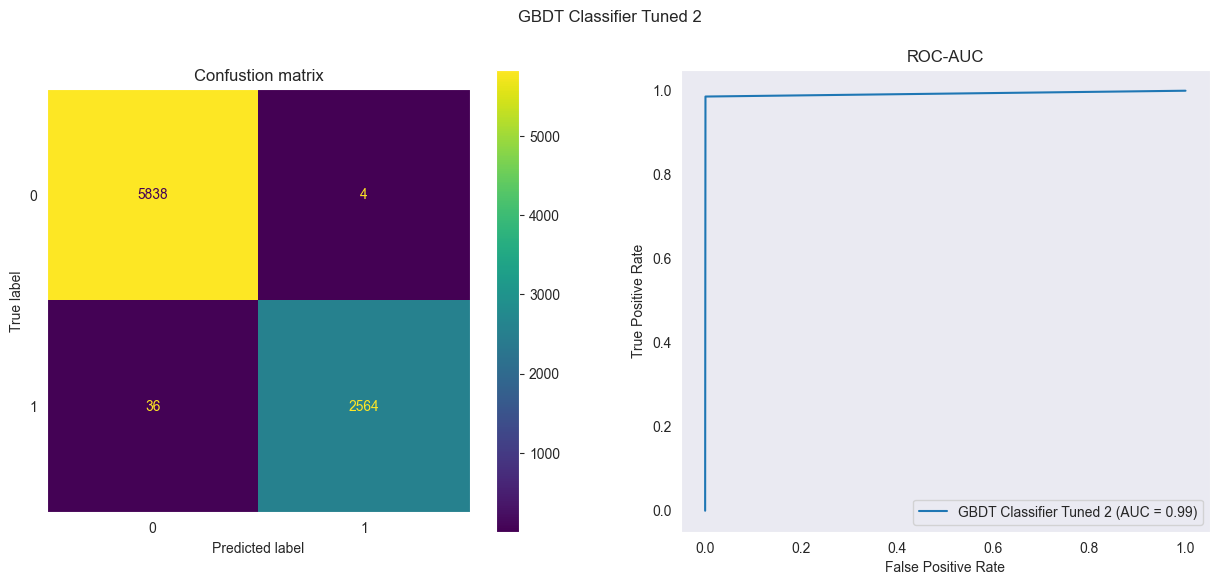

In [54]:
GBDT_model_tuned_2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
GBDT_model_tuned_2.fit(X_train_tfidfvec, y_train)
eval_model(GBDT_model_tuned_2, train_data=X_train_tfidfvec, train_label=y_train, model_name='GBDT Classifier Tuned 2')

Evaluating MLP Classifier...
Training Accuracy =  99.7563  %
Testing Accuracy =  99.5973  %
F1 Score for MLP Classifier: 99.3429 %
cross_validation f1-scores for MLP Classifier 
 [0.99004975 0.99205166 0.99205955]
roc_auc =  99.3888


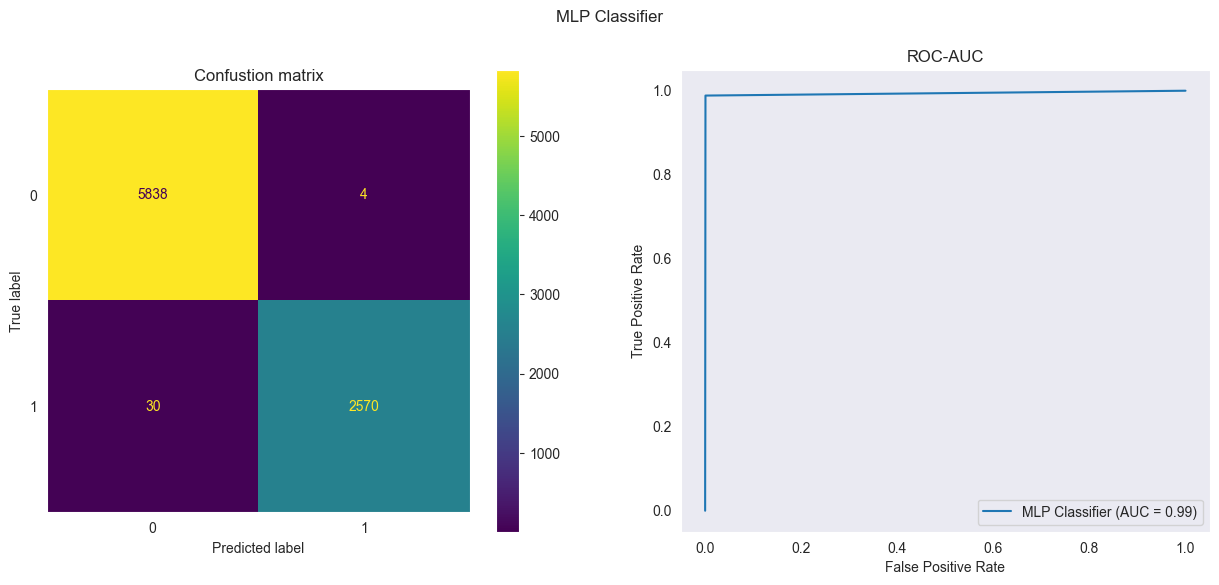

In [55]:
MLP_model = MLPClassifier()
MLP_model.fit(X_train_tfidfvec, y_train)
eval_model(MLP_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='MLP Classifier')

In [56]:
MLP_model_gcv = MLPClassifier()
MLP_params = {'hidden_layer_sizes':((50,),(100,),(200,),(300,),(500,200,))}
MLP_clf_gcv = GridSearchCV(estimator = MLP_model_gcv, param_grid = MLP_params, n_jobs=-1, scoring='f1')
MLP_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'hidden_layer_sizes': ((50,), (100,), (200,), (300,),
                                                (500, 200))},
             scoring='f1')

In [57]:
cv_results = pd.DataFrame(MLP_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
4,"{'hidden_layer_sizes': (500, 200)}",0.992389,0.000769,1
3,"{'hidden_layer_sizes': (300,)}",0.992384,0.000723,2
0,"{'hidden_layer_sizes': (50,)}",0.992300,0.000895,3
2,"{'hidden_layer_sizes': (200,)}",0.992300,0.000774,4
1,"{'hidden_layer_sizes': (100,)}",0.992217,0.000806,5


<Axes: xlabel='param_hidden_layer_sizes', ylabel='mean_test_score'>

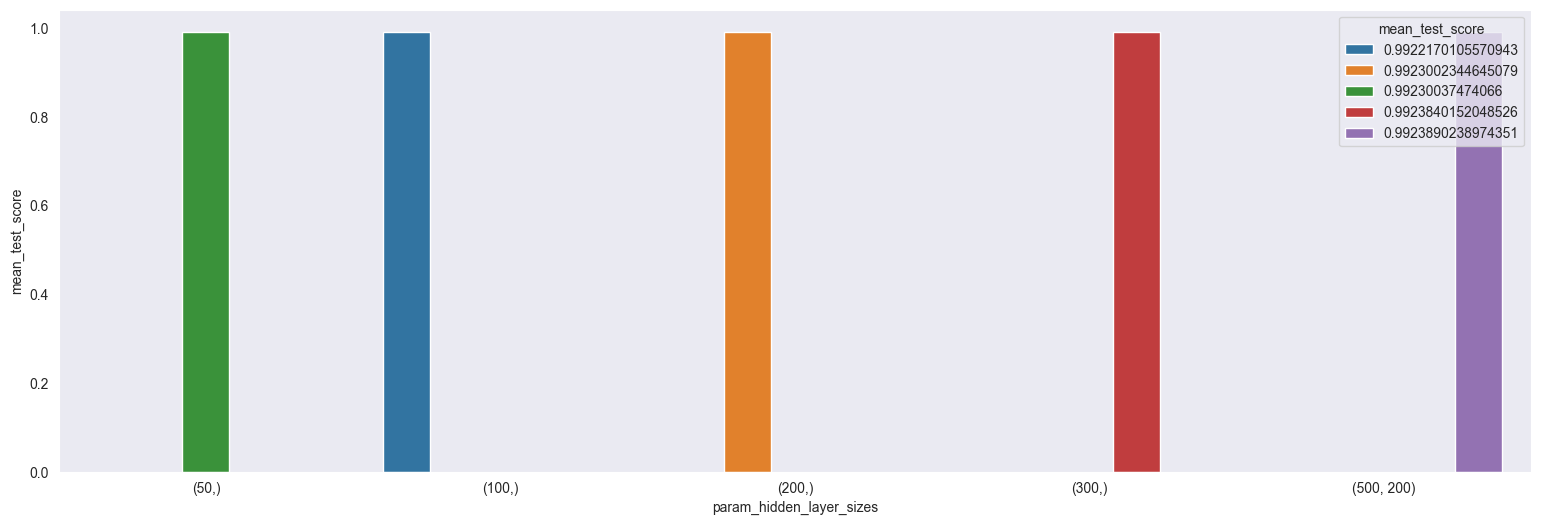

In [58]:
fig = plt.figure(figsize=(19,6))
sns.barplot(data = cv_results, x='param_hidden_layer_sizes', y='mean_test_score', hue='mean_test_score')

Evaluating MLP Classifier Tuned...
Training Accuracy =  99.7614  %
Testing Accuracy =  99.5973  %
F1 Score for MLP Classifier Tuned: 99.3429 %
cross_validation f1-scores for MLP Classifier Tuned 
 [0.99030092 0.99180124 0.99205955]
roc_auc =  99.3888


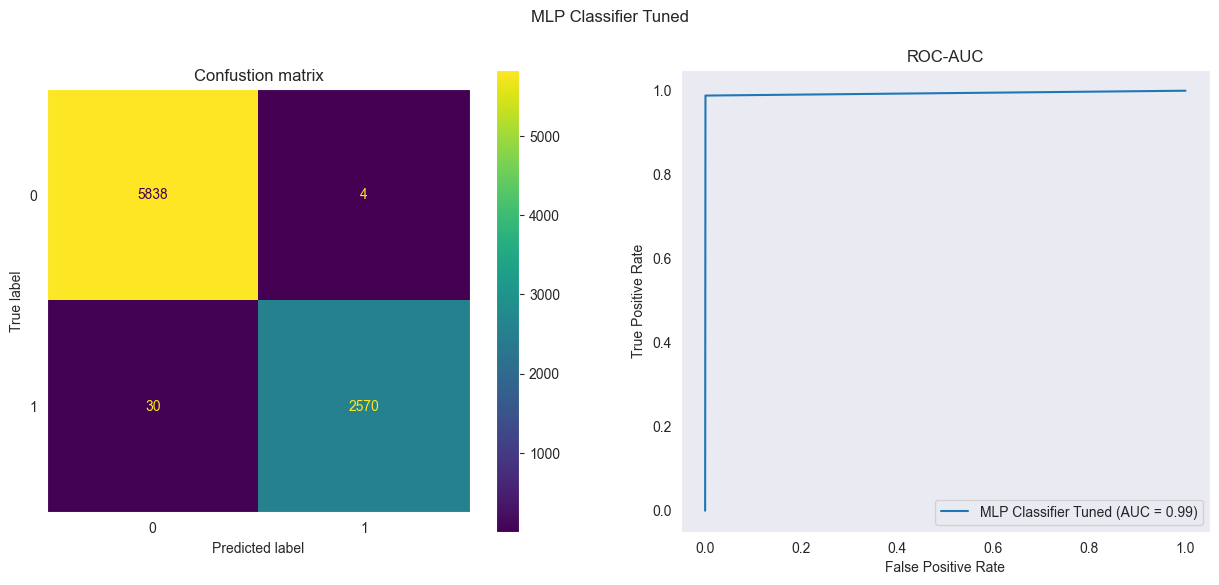

In [59]:
MLP_model_tuned = MLPClassifier(hidden_layer_sizes=(300,))
MLP_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(MLP_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='MLP Classifier Tuned')

In [60]:
final_RFC_model = RandomForestClassifier(n_estimators=50, class_weight='balanced')
final_RFC_model.fit(X_train_tfidfvec, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50)

In [61]:
with open('../model/final_RFC_model.model', 'wb') as file:
  pickle.dump(final_RFC_model, file)

In [62]:
y_pred = final_RFC_model.predict(X_test_tfidfvec)
y_pred.shape

(8442,)

In [63]:
error_idx = y_test.index[y_pred!=y_test]

In [64]:
error_points = pd.DataFrame()
error_points['Qurey'] = X_test[error_idx]
error_points['True_Label'] = y_test[error_idx]
error_points['Pred_Label'] = y_pred[y_pred != y_test]

In [65]:
with pd.option_context('display.max_colwidth', None):
  display(error_points)

,Qurey,True_Label,Pred_Label
19890,select customername city country from customers order by case when city is null then country else city end,0,1
19305,os,1,0
19314,handler,1,0
19312,0,1,0
25803,insert into available doctor sleep happened values lay wrapped function,0,1
658,declare q nvarchar 4000 select q,1,0
106,s,1,0
851,objectclass,1,0
627,having 1 1,1,0
573,declare s varchar 8000 select s 0x73656c,1,0


In [66]:
raw_dataset = pd.read_csv("../data/Modified_SQL_Dataset.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/Modified_SQL_Dataset.csv'

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(raw_dataset.loc[error_idx,:])

,Query,Label
19890,"SELECT CustomerName, City, Country FROM Customers ORDER BY ( CASE WHEN City IS NULL THEN Country ELSE City END ) ;",0
19305,os,1
19314,handler,1
19312,0,1
25803,"INSERT INTO available ( doctor, sleep, happened ) VALUES ( 'lay', 'wrapped', 'function' )",0
658,declare @q nvarchar ( 4000 ) select @q =,1
106,s,1
851,* ( | ( objectclass = * ) ),1
627,having 1 = 1--,1
573,declare @s varchar ( 8000 ) select @s = 0x73656c ...,1


In [ ]:
dataset_FE = dataset_all_cleaned.copy()

In [ ]:
# dataset_FE['Query_length'] =
no_of_special_chars = raw_dataset['Query'].map(lambda x:len(re.findall('[^a-zA-Z0-9\s]',x)))
query_length = dataset_all_cleaned['Query'].map(lambda x:len(x.split()))
no_of_num_eq_num = raw_dataset['Query'].map(lambda x:len(re.findall(r'\d\s*=\s*\d',x))).sort_values(ascending=False)

In [ ]:
dataset_FE['num_eq_num'] = no_of_num_eq_num.loc[dataset_FE.index]
dataset_FE['num_sc'] = no_of_special_chars.loc[dataset_FE.index]
dataset_FE['q_len'] = query_length

In [ ]:
X_train_tfidf_FE = X_train_tfidfvec.copy()
X_test_tfidf_FE = X_test_tfidfvec.copy()

In [ ]:
X_train_tfidf_FE = pd.DataFrame(data=X_train_tfidfvec.toarray(),columns=tfidf_vectorizer.get_feature_names(), index=X_train.index)
X_train_tfidf_FE['num_sc'] = dataset_FE.loc[X_train.index]['num_sc']
X_train_tfidf_FE['q_len'] = dataset_FE.loc[X_train.index]['q_len']
X_train_tfidf_FE['num_eq_num'] = dataset_FE.loc[X_train.index]['num_eq_num']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_tfidf_FE

,01,01 and,01 and 1996,06,06 15,06 15 09,07,07 01,07 01 and,07 31,09,09 34,09 34 21,0x28,0x28 end,0x28 end and,0x2e,0x2e 0x7171706a71,0x2e 0x7171706a71 select,0x4c4d6142,0x4c4d6142 and,0x52515a50,0x5c,0x5c 0x7171706a71,0x5c 0x7171706a71 select,0x5c benchmark,0x5c benchmark 5000000,0x694a4745,0x694a4745 and,0x7171706a71,0x7171706a71 select,0x7171706a71 select case,0x7171706a71 select elt,0x717a767a71,0x717a767a71 0x78,0x717a767a71 0x78 8446744073709551610,0x717a767a71 0x78 and,0x717a767a71 1161,0x717a767a71 1161 and,0x717a767a71 8666,...,wing,wise,wish,without,women,won,wonderful,worse,worth,would,wp,wp options,wp options where,wp postmeta,wp postmeta where,wp posts,wp posts from,wp posts id,wp posts menu,wp posts post,wp posts where,wp term,wrapped,write,writer,wrong,xmltype,xmltype chr,xmltype chr 60,yard,ydpu,ydpu and,year,yes,yourself,zipper,zulu,num_sc,q_len,num_eq_num
26897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,1,5,0
15091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0,2,0
25389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0,4,0
22109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,5,9,0
21007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,4,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,2,5,0
7143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,13,12,0
1525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311098,0.34015,0.0,0.0,0.0,0.0,0.0,17,12,0
18485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
X_test_tfidf_FE = pd.DataFrame(data=X_test_tfidfvec.toarray(),columns=tfidf_vectorizer.get_feature_names(), index=X_test.index)
X_test_tfidf_FE['num_sc'] = dataset_FE.loc[X_test.index]['num_sc']
X_test_tfidf_FE['q_len'] = dataset_FE.loc[X_test.index]['q_len']
X_test_tfidf_FE['num_eq_num'] = dataset_FE.loc[X_test.index]['num_eq_num']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_test_tfidf_FE

,01,01 and,01 and 1996,06,06 15,06 15 09,07,07 01,07 01 and,07 31,09,09 34,09 34 21,0x28,0x28 end,0x28 end and,0x2e,0x2e 0x7171706a71,0x2e 0x7171706a71 select,0x4c4d6142,0x4c4d6142 and,0x52515a50,0x5c,0x5c 0x7171706a71,0x5c 0x7171706a71 select,0x5c benchmark,0x5c benchmark 5000000,0x694a4745,0x694a4745 and,0x7171706a71,0x7171706a71 select,0x7171706a71 select case,0x7171706a71 select elt,0x717a767a71,0x717a767a71 0x78,0x717a767a71 0x78 8446744073709551610,0x717a767a71 0x78 and,0x717a767a71 1161,0x717a767a71 1161 and,0x717a767a71 8666,...,wing,wise,wish,without,women,won,wonderful,worse,worth,would,wp,wp options,wp options where,wp postmeta,wp postmeta where,wp posts,wp posts from,wp posts id,wp posts menu,wp posts post,wp posts where,wp term,wrapped,write,writer,wrong,xmltype,xmltype chr,xmltype chr 60,yard,ydpu,ydpu and,year,yes,yourself,zipper,zulu,num_sc,q_len,num_eq_num
13356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
13109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,0
20932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9,0
27932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,0
28507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,8,0
13513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
22529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12,0
25560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
final_RFC_model_FE = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
final_RFC_model_FE.fit(X_train_tfidf_FE, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

Evaluating RFC model with FE...
Training Accuracy =  99.9086  %
Testing Accuracy =  99.7394  %
F1 Score for RFC model with FE: 99.5756 %
cross_validation f1-scores for RFC model with FE 
 [0.99429139 0.99304866 0.99628437]
roc_auc =  99.6089


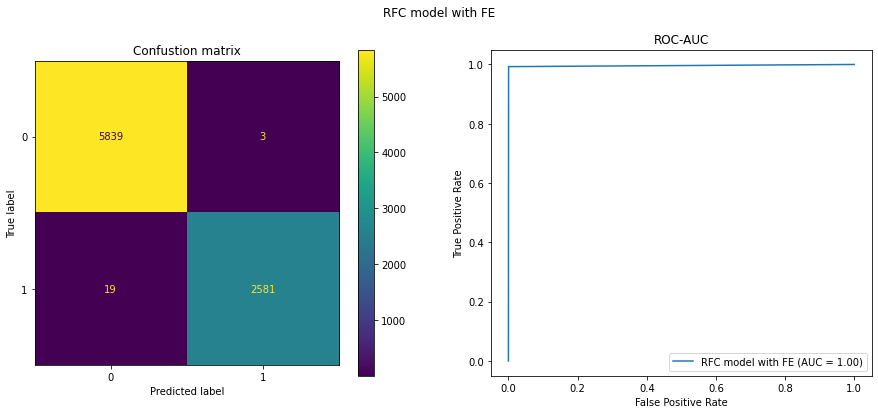

In [ ]:
model = final_RFC_model_FE
train_data=X_train_tfidf_FE
train_label=y_train
model_name='RFC model with FE'

print(f'Evaluating {model_name}...')
train_acc_score = model.score(train_data, train_label)
test_acc_score = model.score(X_test_tfidf_FE, y_test)

print('Training Accuracy = ',round(train_acc_score*100, 4), ' %')
print('Testing Accuracy = ',round(test_acc_score*100, 4), ' %')

y_predictions = model.predict(X_test_tfidf_FE)
print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,4)} %")
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

cross_val_f1 = cross_val_score(model, train_data, train_label, cv=3, scoring='f1')
print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,4))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);

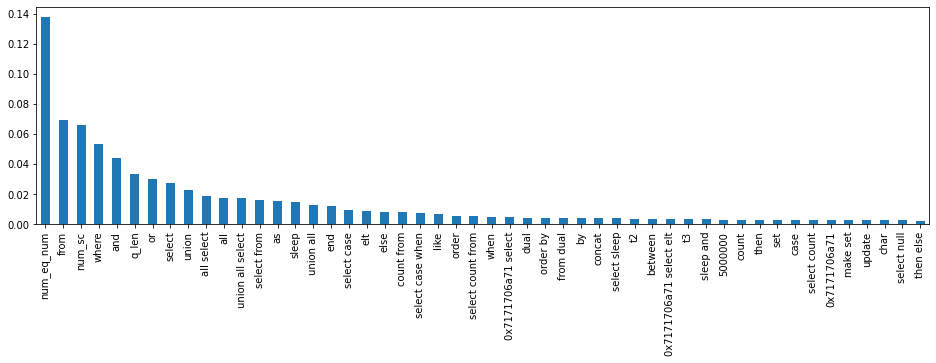

In [ ]:
importances = final_RFC_model_FE.feature_importances_
forest_importances = pd.Series(importances, index=X_train_tfidf_FE.columns)
forest_importances.sort_values(inplace=True, ascending=False)
forest_importances[:50].plot(kind='bar', figsize=(16,4))

In [ ]:
error_idx = y_test.index[final_RFC_model_FE.predict(X_test_tfidf_FE)!=y_test]
with pd.option_context('display.max_colwidth', None):
  display(raw_dataset.loc[error_idx,:])

,Query,Label
19890,"SELECT CustomerName, City, Country FROM Customers ORDER BY ( CASE WHEN City IS NULL THEN Country ELSE City END ) ;",0
19305,os,1
19314,handler,1
19312,0,1
106,s,1
412,bfilename,1
837,having,1
19296,1s,1
25,insert,1
300,@variable,1


In [ ]:
with open('../model/final_RFC_FE_model.model', 'wb') as file:
  pickle.dump(final_RFC_model_FE, file)

In [ ]:
Dataset_FE = (X_train_tfidf_FE, X_test_tfidf_FE, y_train, y_test)
with open('../data/FE_dataset.sav', 'wb') as file:
  pickle.dump(Dataset_FE, file)

In [ ]:
SVC_model_FE = SVC(kernel='linear', C=5.0)
SVC_model_FE.fit(X_train_tfidf_FE, y_train)

SVC(C=5.0, kernel='linear')

Evaluating SVC model with FE...
Training Accuracy =  99.7309  %
Testing Accuracy =  99.6328  %
F1 Score for SVC model with FE: 99.401 %
cross_validation f1-scores for SVC model with FE 
 [0.99205561 0.99082114 0.99404467]
roc_auc =  99.4359


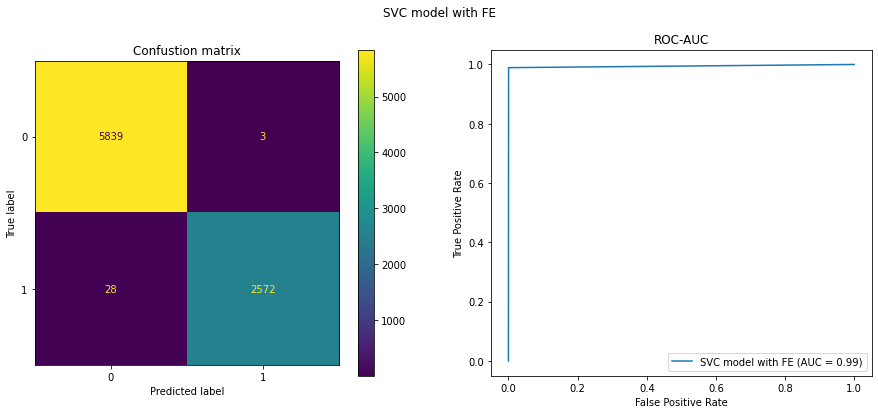

In [ ]:
model = SVC_model_FE
train_data=X_train_tfidf_FE
train_label=y_train
model_name='SVC model with FE'

print(f'Evaluating {model_name}...')
train_acc_score = model.score(train_data, train_label)
test_acc_score = model.score(X_test_tfidf_FE, y_test)

print('Training Accuracy = ',round(train_acc_score*100, 4), ' %')
print('Testing Accuracy = ',round(test_acc_score*100, 4), ' %')

y_predictions = model.predict(X_test_tfidf_FE)
print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,4)} %")
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

cross_val_f1 = cross_val_score(model, train_data, train_label, cv=3, scoring='f1')
print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,4))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);